## get the data from kaggle 

In [ ]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d yenruchen/taiwans-air-quality-data-by-hours
!unzip /content/taiwans-air-quality-data-by-hours.zip                               

 97% 87.0M/89.5M [00:05<00:00, 20.9MB/s]
100% 89.5M/89.5M [00:05<00:00, 18.2MB/s]
Archive:  /content/taiwans-air-quality-data-by-hours.zip
  inflating: file.csv                


# import the librarys

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import preprocessing, feature_selection, svm, model_selection, metrics, impute , linear_model
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf 
from tqdm import tqdm
import pickle as pk 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# read data



```
forecasting task --> regression 
the target column is AQI y
```



In [ ]:
data  = pd.read_csv('file.csv')  

# Preproccesing 


## Convert Chinese terms into English

In [ ]:
data= data [data['County' ] == '新北市'  ]

In [ ]:
data.head(3)

,SiteName,County,AQI,Pollutant,Status,SO2,CO,O3,O3_8hr,PM10,...,WindDirec,DataCreationDate,Unit,CO_8hr,PM2.5_AVG,PM10_AVG,SO2_AVG,Longitude,Latitude,SiteId
1,汐止,新北市,23.0,NaN,良好,0.7,0.26,28,27.0,21.0,...,41.0,2016-11-25 13:00,NaN,0.31,6.0,11.0,NaN,NaN,NaN,NaN
2,萬里,新北市,34.0,NaN,良好,1.2,0.2,42,40.0,31.0,...,65.0,2016-11-25 13:00,NaN,0.2,3.0,36.0,NaN,NaN,NaN,NaN
3,新店,新北市,29.0,NaN,良好,1.3,0.38,31,31.0,11.0,...,99.0,2016-11-25 13:00,NaN,0.36,9.0,6.0,NaN,NaN,NaN,NaN


## sort by Data_Creation_Date

In [ ]:
# sort the records based on the date time 
data['DataCreationDate'] = pd.to_datetime(data['DataCreationDate'] )
data = data.sort_values(['DataCreationDate']) 

In [ ]:
# reset index and drop old index 
data = data.reset_index(drop=True )

In [ ]:
# set index to start from 1 
data.index = data.index+1

In [ ]:
data

3517803

## Drop the unnecessary column.

In [ ]:
# drop these columns for several resons 
# SiteName : its the Air Quality Monitoring Station's Site Name ( not importint for this task)
# County : also it dosent important for this task 
# Unit : contain only nan values 
# SiteId : Air Quality Monitoring Stations' Site Id ( not important for this task )
# Pollutant : Because the sensors do not give the exact percentage of pollution 
# Status  : Because the sensors do not give the exact of air quality 
# Longitude : 
# Latitude :
column=['SiteName','County','Unit' ,'Pollutant','SiteId','Status','Longitude' ,'Latitude']
data = data.drop(columns=column )

## convert columns from categrocal to numercal 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536709 entries, 1 to 536709
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   AQI               531259 non-null  float64       
 1   SO2               524250 non-null  float64       
 2   CO                527634 non-null  object        
 3   O3                522311 non-null  object        
 4   O3_8hr            497989 non-null  object        
 5   PM10              523498 non-null  object        
 6   PM2.5             524837 non-null  object        
 7   NO2               521918 non-null  float64       
 8   NOx               521498 non-null  float64       
 9   NO                521477 non-null  float64       
 10  WindSpeed         470167 non-null  object        
 11  WindDirec         470255 non-null  object        
 12  DataCreationDate  536709 non-null  datetime64[ns]
 13  CO_8hr            532197 non-null  object        
 14  PM2.

In [ ]:
# here we have a proplem problem that there are some of numercal columns contain numbers(float) as a strings so we handle this problem : 

# explore all the data in columns to see what columns contain this problem 
for features in data.columns:
    print(f'  {features} -_-')
    print( f"{data[features].unique()}")
    print('------------------------------')

  AQI -_-
[ 23.  35.  25.  36.  26.  17.  29.  34.  27.  18.  28.  24.  39.  32.
  30.  19.  15.  31.  20.  42.  33.  21.  14.  55.  49.  45.  40.  37.
  41.  44.  46.  47.  nan  48.  50.  51.  38.  52.  53.  54.  56.  57.
  58.  59.  60.  62.  61.  64.  67.  74.  76.  82.  66.  84.  86.  69.
  79.  80.  92.  72.  94.  63.  68.  77.  71.  75.  73.  65.  78.  70.
  43.  22.  89.  96. 104. 107. 117. 128. 102.  99. 109. 112. 138. 125.
 149. 131. 120. 123. 133. 151. 144. 136. 141. 115.  87.  97. 105.  88.
  85.  91.  83.  81.  93.  90.  16.   7. 108. 124. 113. 146. 148. 129.
 116. 134. 142. 110. 114. 135. 139. 140. 127. 119. 130. 132. 143. 145.
 126. 121. 111. 154. 152. 155. 101. 118. 106. 137.  98. 100. 122.  95.
 103. 153. 156. 160. 161. 147. 162. 158. 150. 157.   8.   9. 159. 177.
 174. 164. 166.  12.  13.  11.  10. 185. 187. 172. 179. 169. 190. 203.
 202. 182. 163. 165. 167. 173. 168.   6. 200. 192. 197.  -1.   4.   5.
   1. 195.   2.   3.]
------------------------------
  SO2 -_-
[ 7.

In [ ]:
# then we convert all the nan and string values to a known number to perform pandas function [pd.to_numeric] that not except strings or nan 

data['PM2.5'].replace('ND' ,123456789 , inplace=True)
data = data.replace(np.nan , 123456789 )
data.replace('-', 123456789 ,inplace=True)

 
data.isna().sum()   

AQI                 0
SO2                 0
CO                  0
O3                  0
O3_8hr              0
PM10                0
PM2.5               0
NO2                 0
NOx                 0
NO                  0
WindSpeed           0
WindDirec           0
DataCreationDate    0
CO_8hr              0
PM2.5_AVG           0
PM10_AVG            0
SO2_AVG             0
dtype: int64

In [ ]:
# columns that contain a problem 
x = ['CO','O3','O3_8hr','PM10','PM2.5','WindSpeed','WindDirec','CO_8hr' ,'PM10_AVG'] 
# do a loop and perform the function to convert string numbers to float 
for i in x  : 
  data[i] = pd.to_numeric(data[i], downcast="float")


# then we replace the known number to nan and handle it with imputer 
data.replace(123456789,np.nan , inplace=True)

In [ ]:
data.isna().sum() 

AQI                  5450
SO2                 12459
CO                      0
O3                      0
O3_8hr                  0
PM10                    0
PM2.5                   0
NO2                 14791
NOx                 15211
NO                  15232
WindSpeed               0
WindDirec               0
DataCreationDate        0
CO_8hr                  0
PM2.5_AVG            7498
PM10_AVG                0
SO2_AVG             83717
dtype: int64

## Handling Missing Values 

In [ ]:
# should not be any missing in the data 
data = data[data.AQI.notna()]


In [ ]:
data.isna().sum()

AQI                     0
SO2                  9806
CO                      0
O3                      0
O3_8hr                  0
PM10                    0
PM2.5                   0
NO2                 12090
NOx                 12142
NO                  12163
WindSpeed               0
WindDirec               0
DataCreationDate        0
CO_8hr                  0
PM2.5_AVG            3216
PM10_AVG                0
SO2_AVG             80295
dtype: int64

In [ ]:
date = data['DataCreationDate']
data_to_imp = data.drop(columns='DataCreationDate')

In [ ]:
# we will use the knnImputer to handle missing values 
def handle_missing(data,n_neighbors =5  ):
    columns_name = data.columns
    # initialize the KNNImputer
    imp = impute.KNNImputer(n_neighbors=5, weights="uniform")
    # Fit impute on the dataset
    imp.fit(data)
    # Imputation of missing values
    data = imp.transform(data)
    # Create DataFrame from new_dataset_imp
    data = pd.DataFrame(data,columns=columns_name)
    return data 


In [ ]:
%time 
imp_data = handle_missing(data_to_imp)                             

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [ ]:
imp_data.insert(loc=0, column='time', value=date)

In [ ]:
imp_data.to_csv('imp_data_without_duplecat.csv')

In [ ]:
imp_data.drop(columns='time',inplace=True)

In [ ]:
imp_data['time'] = date

In [ ]:
date.shape, imp_data.shape

((531259,), (531259, 17))

In [ ]:
imp_data.isna().sum()

AQI             0
SO2             0
CO              0
O3              0
O3_8hr          0
PM10            0
PM2.5           0
NO2             0
NOx             0
NO              0
WindSpeed       0
WindDirec       0
CO_8hr          0
PM2.5_AVG       0
PM10_AVG        0
SO2_AVG         0
time         5447
dtype: int64

In [ ]:
x.isna().sum()

0

In [ ]:
imp_data.isna().sum()

AQI          0
SO2          0
CO           0
O3           0
O3_8hr       0
PM10         0
PM2.5        0
NO2          0
NOx          0
NO           0
WindSpeed    0
WindDirec    0
CO_8hr       0
PM2.5_AVG    0
PM10_AVG     0
SO2_AVG      0
dtype: int64

In [ ]:
# data without missing 
imp_data = pd.read_csv('/content/imp_data.csv' )

In [ ]:
imp_data.drop(columns=['Unnamed: 0'] , inplace=True)

In [ ]:
imp_data

,AQI,SO2,CO,O3,O3_8hr,PM10,PM2.5,NO2,NOx,NO,WindSpeed,WindDirec,CO_8hr,PM2.5_AVG,PM10_AVG,SO2_AVG
0,23.0,0.70,0.26,2.800000e+01,27.0,21.0,5.0,11.0,15.0,4.0,2.9,41.0,0.31,6.0,11.0,1.2
1,35.0,1.80,1.19,1.234568e+08,123456792.0,36.0,9.0,32.0,93.0,61.0,123456792.0,123456792.0,1.26,5.0,29.0,3.0
2,25.0,4.30,0.18,3.100000e+01,30.0,19.0,10.0,4.6,5.9,1.4,123456792.0,123456792.0,0.24,7.0,14.0,1.8
3,36.0,1.40,0.23,3.500000e+01,32.0,35.0,12.0,9.5,13.0,3.4,5.7,102.0,0.25,11.0,24.0,1.0
4,25.0,2.30,0.45,3.100000e+01,30.0,25.0,6.0,10.0,14.0,3.1,5.3,87.0,0.39,5.0,14.0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531254,41.0,1.30,0.31,3.390000e+01,32.0,17.0,14.0,10.9,13.1,2.1,1.4,106.0,0.30,12.0,21.0,1.0
531255,32.0,1.20,0.24,3.660000e+01,35.0,9.0,4.0,9.0,9.8,0.7,2.9,81.0,0.20,8.0,18.0,1.0
531256,35.0,1.00,0.26,3.330000e+01,34.0,18.0,10.0,11.3,12.4,1.0,2.5,95.0,0.20,11.0,25.0,1.0
531257,28.0,2.20,0.22,2.960000e+01,30.0,13.0,8.0,14.6,15.8,1.1,1.5,28.0,0.20,8.0,19.0,1.0


# Feture selection 
#### to see the correlation and the most important and effective column to use in our model 

In [ ]:
test_data =data.dropna()

In [ ]:
test_data.isna().sum()

AQI          0
SO2          0
CO           0
O3           0
O3_8hr       0
PM10         0
PM2.5        0
NO2          0
NOx          0
NO           0
WindSpeed    0
WindDirec    0
CO_8hr       0
PM2.5_AVG    0
PM10_AVG     0
SO2_AVG      0
dtype: int64

In [ ]:
test_data = data.sample(n=10000)

In [ ]:
test_x = test_data.drop(columns='AQI') 
test_y = test_data['AQI'] 

In [ ]:
def StandardScaler (x,y, only_scaling = False):
  if only_scaling :
      x_normalizer = preprocessing.StandardScaler()
      x_norm = x_normalizer.fit_transform(x)
  return  x_norm ,y

In [ ]:
x_test_norm, test_y = StandardScaler(test_x, test_y , only_scaling = True)

In [ ]:
# Define the cross validation method
kfold = model_selection.ShuffleSplit(n_splits=10,random_state=42)
# Define empty dictionary for records
# k equal to number Features to Select
best_k = {
    'k':[],
    'msr':[],
    'mab':[]
}

for k in tqdm(range(len(test_x.columns))):
    msr = []
    mab = []
    k +=1

    # Create the linear model
    lsvc = svm.SVR(kernel='linear',max_iter=-1)
    # Define the feature selection method
    feature_selector = feature_selection.RFE(lsvc,n_features_to_select=k)
    # fit the feature Selection method on the x_norm and y
    feature_selector.fit(x_test_norm,test_y)
    # get the new fetures 
    new_x = feature_selector.transform(x_test_norm)
    # Evaluate svm on the features for defiant k values form 1 to 20
    print(test_x.iloc[:,feature_selector.get_support()].columns)

    x_train,x_test,y_train,y_test = model_selection.train_test_split(new_x,test_y,test_size=0.3 )

    model = svm.SVR()
    model.fit(x_train,y_train)
    pred = model.predict(x_test) 


    msr.append( metrics.mean_squared_error(y_test,pred))
    mab.append( metrics.mean_absolute_error(y_test,pred))


    best_k['k'].append(k)
    best_k['msr'].append(msr)
    best_k['mab'].append(mab)
    




  0%|          | 0/15 [00:00<?, ?it/s]

Index(['PM2.5_AVG'], dtype='object')


  7%|▋         | 1/15 [01:13<17:13, 73.83s/it]

Index(['PM2.5', 'PM2.5_AVG'], dtype='object')


 13%|█▎        | 2/15 [02:23<15:27, 71.38s/it]

Index(['PM2.5', 'WindSpeed', 'PM2.5_AVG'], dtype='object')


 20%|██        | 3/15 [03:28<13:43, 68.59s/it]

Index(['PM2.5', 'WindSpeed', 'WindDirec', 'PM2.5_AVG'], dtype='object')


 27%|██▋       | 4/15 [04:30<12:03, 65.78s/it]

Index(['PM2.5', 'NOx', 'WindSpeed', 'WindDirec', 'PM2.5_AVG'], dtype='object')


 33%|███▎      | 5/15 [05:29<10:32, 63.25s/it]

Index(['PM2.5', 'NOx', 'NO', 'WindSpeed', 'WindDirec', 'PM2.5_AVG'], dtype='object')


 40%|████      | 6/15 [06:25<09:07, 60.88s/it]

Index(['PM2.5', 'NOx', 'NO', 'WindSpeed', 'WindDirec', 'PM2.5_AVG', 'SO2_AVG'], dtype='object')


 47%|████▋     | 7/15 [07:14<07:36, 57.05s/it]

Index(['PM10', 'PM2.5', 'NOx', 'NO', 'WindSpeed', 'WindDirec', 'PM2.5_AVG',
       'SO2_AVG'],
      dtype='object')


 53%|█████▎    | 8/15 [07:59<06:12, 53.26s/it]

Index(['O3_8hr', 'PM10', 'PM2.5', 'NOx', 'NO', 'WindSpeed', 'WindDirec',
       'PM2.5_AVG', 'SO2_AVG'],
      dtype='object')


 60%|██████    | 9/15 [08:39<04:54, 49.06s/it]

Index(['O3', 'O3_8hr', 'PM10', 'PM2.5', 'NOx', 'NO', 'WindSpeed', 'WindDirec',
       'PM2.5_AVG', 'SO2_AVG'],
      dtype='object')


 67%|██████▋   | 10/15 [09:14<03:43, 44.77s/it]

Index(['O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'PM2.5_AVG', 'SO2_AVG'],
      dtype='object')


 73%|███████▎  | 11/15 [09:44<02:40, 40.19s/it]

Index(['CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'PM2.5_AVG', 'SO2_AVG'],
      dtype='object')


 80%|████████  | 12/15 [10:09<01:46, 35.64s/it]

Index(['CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'PM2.5_AVG', 'PM10_AVG', 'SO2_AVG'],
      dtype='object')


 87%|████████▋ | 13/15 [10:31<01:02, 31.42s/it]

Index(['CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed',
       'WindDirec', 'CO_8hr', 'PM2.5_AVG', 'PM10_AVG', 'SO2_AVG'],
      dtype='object')


 93%|█████████▎| 14/15 [10:45<00:26, 26.35s/it]

Index(['SO2', 'CO', 'O3', 'O3_8hr', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO',
       'WindSpeed', 'WindDirec', 'CO_8hr', 'PM2.5_AVG', 'PM10_AVG', 'SO2_AVG'],
      dtype='object')


100%|██████████| 15/15 [10:55<00:00, 43.72s/it]


In [ ]:
scores_df = pd.DataFrame(best_k)
scores_df

,k,msr,mab
0,1,[78.85421196941222],[4.473712548761201]
1,2,[77.85028271125466],[4.408504580635225]
2,3,[84.79998794712273],[4.695106125616681]
3,4,[100.88852278937665],[4.975065694255703]
4,5,[92.4636182041307],[4.953847570529443]
5,6,[99.83617779124509],[5.078380993453724]
6,7,[97.75624398344058],[5.224292899615486]
7,8,[99.59518139166696],[5.282835509298026]
8,9,[104.93503834276383],[5.537932121152758]
9,10,[115.8129573259715],[5.763499028353193]


In [ ]:
# feture selection on all data
x = imp_data.drop(columns='AQI') 
y = imp_data['AQI']  

In [ ]:
x_norm,y = StandardScaler(x,y , only_scaling = True)

In [ ]:
x_norm

array([[-0.80879058, -0.11152042, -0.31510923, ..., -0.93540578,
        -0.13704752, -0.66735104],
       [-0.19903485, -0.11152035,  3.17350357, ..., -1.04979564,
        -0.13704643,  0.85118395],
       [ 1.18677362, -0.11152043, -0.31510915, ..., -0.82101591,
        -0.13704734, -0.16117271],
       ...,
       [-0.64249357, -0.11152042, -0.31510908, ..., -0.36345644,
        -0.13704667, -0.83607714],
       [ 0.0226945 , -0.11152042, -0.31510919, ..., -0.70662604,
        -0.13704704, -0.83607714],
       [-1.04160641, -0.11152043, -0.31510858, ..., -0.47784631,
        -0.13704619, -1.67970769]])

In [ ]:
ln= linear_model.LinearRegression()
feature_selector = feature_selection.RFE(ln,n_features_to_select=12)
# select the best features 
#  سويتله فت ع الترين داتا 
feature_selector.fit(x_norm,y) 

#  هسه سويتله ترانسفورم ع الفيتشرات مالتي و رجعت الحجم حته اعرف كم عمود 
new_x =feature_selector.transform(x_norm)# get the best features using the pretrained model
new_x.shape

(531259, 12)

In [ ]:
selected_col = feature_selector.get_support()
x.loc[:,selected_col]    

,SO2,PM10,PM2.5,NO2,NOx,NO,WindSpeed,WindDirec,CO_8hr,PM2.5_AVG,PM10_AVG,SO2_AVG
0,0.70,21.0,5.0,11.0,15.0,4.0,2.9,41.0,0.31,6.0,11.0,1.2
1,1.80,36.0,9.0,32.0,93.0,61.0,123456792.0,123456792.0,1.26,5.0,29.0,3.0
2,4.30,19.0,10.0,4.6,5.9,1.4,123456792.0,123456792.0,0.24,7.0,14.0,1.8
3,1.40,35.0,12.0,9.5,13.0,3.4,5.7,102.0,0.25,11.0,24.0,1.0
4,2.30,25.0,6.0,10.0,14.0,3.1,5.3,87.0,0.39,5.0,14.0,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...
531254,1.30,17.0,14.0,10.9,13.1,2.1,1.4,106.0,0.30,12.0,21.0,1.0
531255,1.20,9.0,4.0,9.0,9.8,0.7,2.9,81.0,0.20,8.0,18.0,1.0
531256,1.00,18.0,10.0,11.3,12.4,1.0,2.5,95.0,0.20,11.0,25.0,1.0
531257,2.20,13.0,8.0,14.6,15.8,1.1,1.5,28.0,0.20,8.0,19.0,1.0


In [ ]:
feture_selected_data = x.loc[:,selected_col] 

In [ ]:
feture_selected_data['AQI'] = y

<ipython-input-57-6f25e41b2323>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feture_selected_data['AQI'] = y


In [ ]:
feture_selected_data.columns

Index(['SO2', 'PM10', 'PM2.5', 'NO2', 'NOx', 'NO', 'WindSpeed', 'WindDirec',
       'CO_8hr', 'PM2.5_AVG', 'PM10_AVG', 'SO2_AVG', 'AQI'],
      dtype='object')

In [ ]:
feture_selected_data = pd.read_csv('/content/feture_selected_data.csv')
feture_selected_data.drop(columns=['Unnamed: 0'] , inplace=True)
feture_selected_data

,SO2,PM10,PM2.5,NO2,NOx,NO,WindSpeed,WindDirec,CO_8hr,PM2.5_AVG,PM10_AVG,SO2_AVG,AQI
0,0.70,21.0,5.0,11.0,15.0,4.0,2.9,41.0,0.31,6.0,11.0,1.2,23.0
1,1.80,36.0,9.0,32.0,93.0,61.0,123456792.0,123456792.0,1.26,5.0,29.0,3.0,35.0
2,4.30,19.0,10.0,4.6,5.9,1.4,123456792.0,123456792.0,0.24,7.0,14.0,1.8,25.0
3,1.40,35.0,12.0,9.5,13.0,3.4,5.7,102.0,0.25,11.0,24.0,1.0,36.0
4,2.30,25.0,6.0,10.0,14.0,3.1,5.3,87.0,0.39,5.0,14.0,1.8,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531254,1.30,17.0,14.0,10.9,13.1,2.1,1.4,106.0,0.30,12.0,21.0,1.0,41.0
531255,1.20,9.0,4.0,9.0,9.8,0.7,2.9,81.0,0.20,8.0,18.0,1.0,32.0
531256,1.00,18.0,10.0,11.3,12.4,1.0,2.5,95.0,0.20,11.0,25.0,1.0,35.0
531257,2.20,13.0,8.0,14.6,15.8,1.1,1.5,28.0,0.20,8.0,19.0,1.0,28.0


# modeling

In [ ]:
data.DataCreationDate = pd.to_datetime(data.DataCreationDate)

In [ ]:
data['DataCreationDate'].head(23)

1    2016-11-25 13:00:00
2    2016-11-25 13:00:00
3    2016-11-25 13:00:00
4    2016-11-25 13:00:00
5    2016-11-25 13:00:00
6    2016-11-25 13:00:00
7    2016-11-25 13:00:00
8    2016-11-25 13:00:00
9    2016-11-25 13:00:00
10   2016-11-25 13:00:00
11   2016-11-25 13:00:00
12   2016-11-25 14:00:00
13   2016-11-25 14:00:00
14   2016-11-25 14:00:00
15   2016-11-25 14:00:00
16   2016-11-25 14:00:00
17   2016-11-25 14:00:00
18   2016-11-25 14:00:00
19   2016-11-25 14:00:00
20   2016-11-25 14:00:00
21   2016-11-25 14:00:00
22   2016-11-25 14:00:00
23   2016-11-25 15:00:00
Name: DataCreationDate, dtype: datetime64[ns]

In [ ]:
# check if all the hours have the same numbers of records 
df = data.copy()
df['hour'] = df['DataCreationDate'].dt.hour

# count the number of records for each hour
hour_counts = df['hour'].value_counts()

# check if there are any hours with less than 11 records
if (hour_counts < 11).any():
    print("There are hours with less than 11 records.")

else:
    print("All hours have at least 11 records.")

All hours have at least 11 records.


In [ ]:
# this data are sorted and have 11 records by hour 
# meaning each 11 records == 1 hour 
# each 264 records  == 1 day 

data_df = pd.read_csv('/content/drive/MyDrive/air_quality/code/new_data.csv') 
data_df.drop(columns=['Unnamed: 0'] , inplace=True)
data_df                           

,SO2,PM10,PM2.5,NO2,NOx,NO,WindSpeed,WindDirec,CO_8hr,PM2.5_AVG,PM10_AVG,SO2_AVG,AQI
0,-0.808791,-0.424476,-0.896833,-0.299598,-0.279465,-0.222149,0.387556,-0.753286,-0.352225,-0.935406,-1.019249,-0.667351,-1.089772
1,-0.199035,0.308983,-0.495300,1.605054,2.854538,3.248158,-1.051768,-1.161737,2.508674,-1.049796,-0.046101,0.851184,-0.577691
2,1.186774,-0.522270,-0.394917,-0.880064,-0.645098,-0.380443,-1.051768,-1.161737,-0.563028,-0.821016,-0.857057,-0.161173,-1.004425
3,-0.420764,0.260086,-0.194151,-0.435645,-0.359824,-0.258678,1.777248,-0.145592,-0.532913,-0.363456,-0.316420,-0.836077,-0.535018
4,0.078127,-0.228887,-0.796450,-0.390296,-0.319644,-0.276943,1.578721,-0.295025,-0.111307,-1.049796,-0.857057,-0.161173,-1.004425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531254,-0.476197,-0.620065,0.006615,-0.308668,-0.355806,-0.337826,-0.356922,-0.105743,-0.382340,-0.249067,-0.478611,-0.836077,-0.321651
531255,-0.531629,-1.011243,-0.997216,-0.480994,-0.488398,-0.423061,0.387556,-0.354798,-0.683487,-0.706626,-0.640802,-0.836077,-0.705711
531256,-0.642494,-0.571168,-0.394917,-0.272389,-0.383932,-0.404796,0.189028,-0.215327,-0.683487,-0.363456,-0.262356,-0.836077,-0.577691
531257,0.022695,-0.815654,-0.595683,0.026913,-0.247321,-0.398708,-0.307290,-0.882795,-0.683487,-0.706626,-0.586738,-0.836077,-0.876405


In [ ]:
time_serises = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data_df, data_df.AQI, length=60, batch_size=32
)
     

# get the first batch of the dataset
x, y = time_serises[0]

In [ ]:
x.shape , y.shape

((32, 60, 13), (32,))

In [ ]:
# create empty nummpy array to store the data

x_data = np.array([])
# create empty nummpy array to store the target
y_data = np.array([])
# loop through the dataset and append the data and target to the empty arrays
for x, y in tqdm(time_serises):
    # append the data to the x_data array
    x_data = np.append(x_data, x)
    # append the target to the y_data array
    y_data = np.append(y_data, y)           
    

100%|██████████| 16600/16600 [2:48:35<00:00,  1.64it/s]


In [ ]:
x_data.shape , y_data.shape

((414335220,), (531199,))

In [ ]:
# # to save any type of files or data 
# with open('/content/drive/MyDrive/air_quality/data_ffill/x_y_data.p','wb') as f :

#   pk.dump({'x':x_data,'y':y_data},f) 




In [ ]:
# Load the saved data
try:
    with open('/content/drive/MyDrive/air_quality/data_ffill/x_y_data.p', 'rb') as f:
        data = pk.load(f)
except EOFError:
    print("Error: The file contains no data.")
    data = None

if data:
    # Access the loaded data
    x = data['x']
    y = data['y']


In [ ]:
print(x.shape , y.shape)

(414335220,) (531199,)


In [ ]:
# make sure the data is of shape (batch_size,length,1) and the target is of shape (batch_size,1)
x = x.reshape(-1, 60, 13)
y = y.reshape(-1, 1)

In [ ]:
x.shape

(531199, 60, 13)

In [ ]:
y.shape , x.shape

((531199, 1), (31871940, 13, 1))

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
# x_train.shape , x_test.shape, y_train.shape,y_test.shape 

((424959, 60, 13), (106240, 60, 13), (424959, 1), (106240, 1))

In [ ]:
# with open('/content/drive/MyDrive/air_quality/data_ffill/x_train_y_train','wb') as f :
    #  pk.dump({'x_train':x_train,'x_test':x_test ,'y_train':y_train,'y_test':y_test},f)

In [ ]:
with open('/content/drive/MyDrive/air_quality/data_ffill/x_train_y_train', 'rb') as f:
    XTYTDATA = pk.load(f)
x_train = XTYTDATA['x_train']
x_test = XTYTDATA['x_test']
y_train =XTYTDATA['y_train']
y_test = XTYTDATA['y_test']    

In [ ]:
x_train.shape ,x_test.shape , y_train.shape,y_test.shape

((318719, 60, 13), (212480, 60, 13), (318719, 1), (212480, 1))

# model_1


In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
class Air_Quality_Model(tf.keras.Model):
  def __init__(self): 
  
    super(Air_Quality_Model, self).__init__()


    self.conv1 = tf.keras.layers.Conv1D(128, 5, padding='same', use_bias=True)
    self.Layer1 =  tf.keras.layers.LayerNormalization()

    self.conv2 = tf.keras.layers.Conv1D(64, 5, padding='same', use_bias=True)
    self.Layer2 =  tf.keras.layers.LayerNormalization()

   
    self.bi3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True) ) 
    self.Layer3 = tf.keras.layers.LayerNormalization()

    self.lstm4 =tf.keras.layers.LSTM(128, return_sequences=True )
    self.Layer4 = tf.keras.layers.LayerNormalization()

    self.lstm5 =tf.keras.layers.LSTM(64, return_sequences=True )
    self.Layer5 = tf.keras.layers.LayerNormalization()
    
    self.GRU6 =tf.keras.layers.GRU(64, return_sequences=True )
    self.Layer6 = tf.keras.layers.LayerNormalization()

    self.GRU7 =tf.keras.layers.GRU(32, return_sequences=True )
    self.Layer7 = tf.keras.layers.LayerNormalization()


    self.lstm8 = tf.keras.layers.LSTM(1)



   
# نعرف هاي الفكشن الي تربط لايرات ببعضهن و تاخذ الانبوت   و تمرره للاير الاولى و ناتجها يمر للاير الي بعدها 
  def call(self, inputs):
    
    x = self.conv1(inputs)
    x = self.Layer1(x) 
    x = tf.nn.relu(x)

    x = self.conv2(x)
    x = self.Layer2(x)    
    x = tf.nn.relu(x)
    
    x = self.bi3(x)
    x = self.Layer3(x)

    x = self.lstm4(x)
    x = self.Layer4(x)

    x = self.lstm5(x)
    x = self.Layer5(x)

    x = self.GRU6(x)
    x = self.Layer6(x)

    x = self.GRU7(x)
    x = self.Layer7(x)


    outputs = self.lstm8(x)    

    
    return outputs




In [ ]:
model = Air_Quality_Model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.Huber(),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.mean_squared_error],
)







In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/air_quality/data_ffill/model_checkpoint5",
    save_best_only=True,
    monitor="val_loss",
)

In [ ]:
model.fit(
     x_train,y_train,
     epochs=5,
     validation_data=(x_test,y_test),
     callbacks=[checkpoint_callback],       
 )  

In [ ]:
x_sampel = np.expand_dims(x[-1000,:,:],0)
y_sampel = y[-1000:]

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/air_quality/data_ffill/model_checkpoint5')

In [ ]:
p = []
v = []
for i in tqdm(range(1000)):
    p.append(model.predict(np.expand_dims(x[-i,:,:],0)))
    v.append(y[-i])

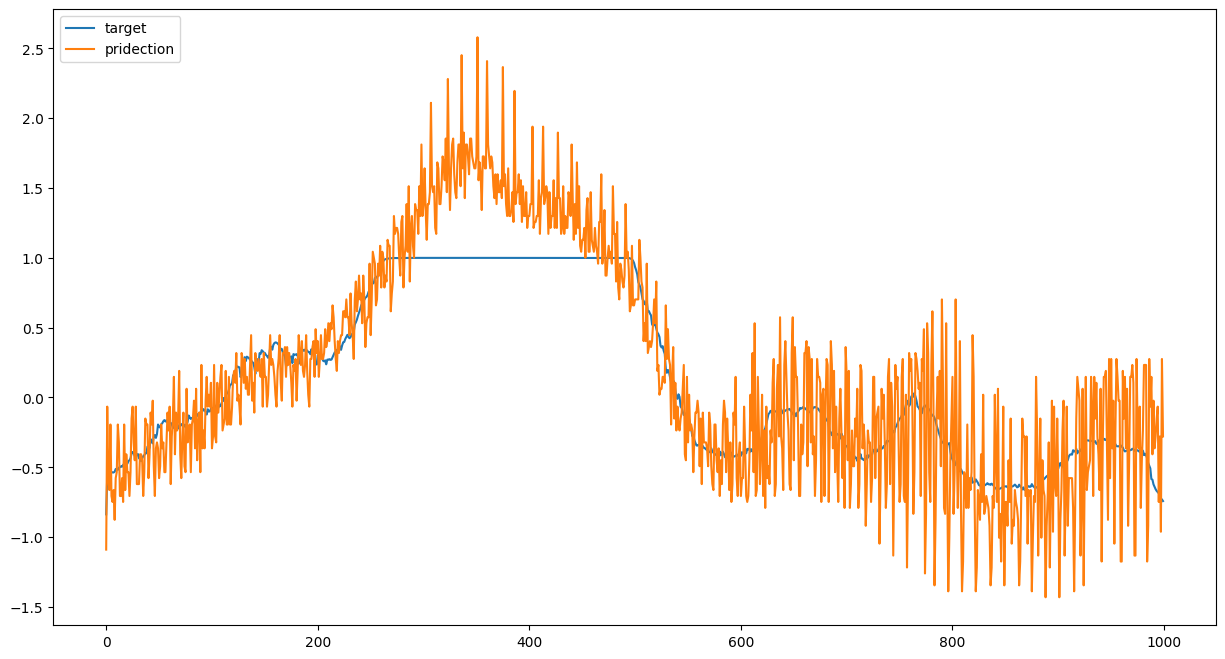

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(np.array(p).reshape(-1))
plt.plot(v)
plt.legend(['target','pridection'], loc='upper left',)
plt.show()